# Exp 018: Instruction fine-tuning for constrained text generation
This experiment aims at instruction fine-tuning from existing skills in the dataset to train the model on single constraints.

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['CACHE_DIR'] = os.environ['FAST_CACHE_DIR'].replace("%SLURM_JOB_ID%", os.getenv('SLURM_JOB_ID')) # speed up model loading
os.environ['WANDB_DIR'] = os.getenv('CACHE_DIR')

from tqdm.notebook import tqdm
from transformers import TrainingArguments, AutoTokenizer
import datasets
datasets.disable_caching()

import random
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
import pickle
from torch.utils.data import RandomSampler
from collections import defaultdict
import numpy as np
import pandas as pd
import json
from peft import LoraConfig, PeftModel, get_peft_model
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
import sys
sys.path.append(f'../source')
import helpers
import models
import evaluation
import importlib
#importlib.reload(helpers)

2024-04-29 16:13:10.251805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.57040927.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# params
input_file = '../data/corpus_classification_all.pkl'
preprossed_dataset_file = '../data/SFT_data_multi.jsonl'
checkpoint_dir = '/cluster/scratch/dglandorf/models/'
nrs = list(evaluation.detector.classifiers.keys())
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"#"mistralai/Mistral-7B-Instruct-v0.2"#
nrs_to_consider = helpers.get_high_conf_classifiers()

## Prepare dataset

In [3]:
if not os.path.exists(preprossed_dataset_file):
    with open(input_file, 'rb') as f:
        all_hit_indices = pickle.load(f)
        all_hit_sentences = pickle.load(f)
        extracts = pickle.load(f)
    
    data = [{"context": extracts[idx][0],
             "response": extracts[idx][1],
             "constraints": [nr],
             "source": extracts[idx][2],} for nr in nrs_to_consider for idx in all_hit_indices[nr]]
    multi_constraints = [
        {"context": extract[0],
         "response": extract[1],
         "constraints": [nr for nr in nrs_to_consider if idx in all_hit_indices[nr]],
         "source": extract[2],} for idx, extract in tqdm(enumerate(extracts), total=len(extracts))]
    multi_constraints = [item for item in multi_constraints if len(item['constraints'])>1]
    data = data + multi_constraints
    
    with open(preprossed_dataset_file, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

### Load dataset

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=os.getenv('CACHE_DIR'), padding_side="right")
tokenizer.pad_token = tokenizer.eos_token
terminators = [tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|eot_id|>")] if "llama" in model_name else [2,32000]

dataset = datasets.load_dataset('json', data_files=preprossed_dataset_file, split='train')

count_constraints = defaultdict(int)
def softbalance_constraints(item, max_per_constraint=500):
    constraint_str = "_".join([str(nr) for nr in item['constraints']])
    if count_constraints[constraint_str] > max_per_constraint:
        return False
    else:
        count_constraints[constraint_str] += 1
        return True
dataset = dataset.filter(softbalance_constraints)
dataset = dataset.map(helpers.get_generation_prompt,
                      fn_kwargs={"apply_chat_template": tokenizer.apply_chat_template,
                                 "system_msg": "mistral" not in model_name})

seen_texts = set()
def filter_duplicates(item, variable="text"):
    if item[variable] in seen_texts:
        return False
    else:
        seen_texts.add(item[variable])
        return True
dataset = dataset.filter(filter_duplicates)

train_test_split = dataset.train_test_split(test_size=256 if len(dataset)>1024 else 0.2)
train_dataset, test_dataset = train_test_split['train'], train_test_split['test']
unconstrained = test_dataset.map(helpers.get_generation_prompt,
                                 fn_kwargs={"apply_chat_template": tokenizer.apply_chat_template,
                                            "unconstrained": True})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Filter:   0%|          | 0/202632 [00:00<?, ? examples/s]

Map:   0%|          | 0/37140 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37140 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

## Load and prepare base model

In [5]:
model, tokenizer = models.load_generator(model_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Inference with current model

In [21]:
i=18 # pick an item index from the dataset
print(test_dataset['prompt'][i])
print(test_dataset['messages'][i][-1]['content'])
models.generate(model, tokenizer, [test_dataset['prompt'][i]], eos_token_id=terminators, verbose=False, do_sample=False)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output A's response.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of A that includes all of these grammatical items:
- would - FORM: AFFIRMATIVE: Can use the affirmative form.(CEFR A2)
- negation - FORM: MODAL VERB 'CAN': Can use negative form 'can't'.(CEFR A1)
- negation - FORM: AUXILIARY VERB 'DO', PAST: Can form negative statements of main verbs in the past simple with 'didn't' + main verb. ► past simple(CEFR A2)
Dialog:
A: It's crazy to think that the Earth and the people on it could use up one of the basic elements, and yet we still use it to fill birthday party balloons!
B: Wonder if it has anything to do with changing climates, like 71% of Earths's surface is covered in water and the polar regions in ice, but that ice is rapidly decreasing with the drastic climate changes.
A: I think it also has to do with people using it. We've developed such advanced technology 

Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


"A: I would think that's a good idea, addressing these issues at the G20 summit, but I'm not sure if the leaders would actually take action."

## Evaluate outputs

In [6]:
def compute_metrics(eval_preds, verbose=False, n=128, datasets={"test": test_dataset}, eval_quality=False, ground_truth=False, do_sample=False):
    results = {}
    for name, ds in datasets.items():
        subset = ds[RandomSampler(ds, num_samples=min(n, len(ds)))]
        if verbose: print(subset['prompt'][0])
        if ground_truth:
            outputs = subset['response']
        else:
            outputs = models.generate(model, tokenizer, subset['prompt'], verbose=verbose, do_sample=do_sample, eos_token_id=terminators, batch_size=8)
        scores, distinct, quality = evaluation.calc_metrics(subset['context'], outputs, subset['constraints'], eval_quality)
        if verbose:
            for truth, output in zip(subset['response'], outputs):
                print(f"Truth: {truth}")
                print(f"Gener: {output}")
            print(f"Grammar detected: {scores}")
            print(f"Distinctiveness per constraint {distinct}")
            print(f"Quality: {quality}")
        print(list(zip(outputs,scores))[:10])
        
        results.update({f"{name}_constraint": np.mean(scores)})
        results.update({f"{name}_{metric}": np.mean(quality[metric]) for metric in quality.keys()})
        results.update({f"{name}_distinct": np.mean(distinct)})
        models.clean_tensors()
    return results

#compute_metrics([], verbose=False, n=5, datasets={"test": test_dataset}, eval_quality=False, ground_truth=False) # test

In [7]:
all_metrics = {}
all_metrics.update(compute_metrics([], datasets={"truth": unconstrained}, eval_quality=False, ground_truth=True))
all_metrics.update(compute_metrics([], datasets={"base": test_dataset}, eval_quality=False))
all_metrics.update(compute_metrics([], datasets={"unconstrained": unconstrained}, eval_quality=False))

/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


[('I would get DEL if I were you.', 1.0), ("I do, I also find it frightening that dying in a dream, at least one of this nature where heavy sedatives are involved, would send the dying person to limbo instead of waking them up. How would you feel arriving in a world almost impossible to escape from made of infinite subconscious. If it weren\n'", 1.0), ("I am not sure where you can learn but I would just google it. There must be many schools though because the auto industry started in the 1890's and hundreds of different manufacturers got involved. So there must be load of schools all over the US.", 1.0), ("Well, did you enjoy the trip? I have never been to New York. I'd like to go there someday.", 1.0), ('I guess they thought that would have an effect on the other team. Not likely to do much. Or everyone would do it.', 1.0), ("Did you get another movie? Mine's not showing up...", 1.0), ('That is, if Elsa had learned to master her magic rather than ignore it, it would have been a very d

Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [03:48<00:00,  7.13s/it]


[("A: That's a huge order, the largest order we've ever received in this quarter.", 0.0), ("A: But I don't think it would be a good idea to assume that the visiting team would be distracted by the pink locker room, because they're probably used to seeing weird things on the road.", 0.0), ("A: But I'm not sure I agree with the last point, I think it's not that simple to just go out there and network in person, it's not that effective for introverts like me.", 0.0), ("Here's a possible next turn of A:\n\nA: That's amazing! I've heard she's one of the highest-paid TV judges, making millions per episode.", 0.5), ("A: Didn't they ever get angry with you for not going out?", 1.0), ("I don't think it's surprising that the native Americans didn't have a written record of their cooking methods, not many cultures do.", 0.5), ("A: That's great to know! I'm particularly excited to visit the most popular museums in the US, such as the Metropolitan Museum of Art in New York City, which is one of the

Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [05:50<00:00, 10.96s/it]


[('Here is a possible next turn of A that includes all the grammatical items:\n\nA: I was so upset, I went to HR and filed a formal complaint, and I also documented everything that happened, including the exact mistakes he made and the conversation we had about it.', 0.0), ("Here's a possible next turn for A:\n\nA: I think it was a huge mistake on Loki's part. Coulson was a great character and a great leader. He was the heart of S.H.I.E.L.D.", 0.0), ('Here\'s a possible next turn for A:\n\nA: (laughs) Well, I think you might have to brush up on your Norwegian first, but I\'m glad to have inspired your new career goal! And speaking of books, I\'ve always thought it would be cool if libraries had a "maker space" section where you could check out equipment like 3D printers or laser cutters.', 0.2), ("Here's a possible next turn for A:\n\nA: Yeah, it's crazy to think about what could have been if Michael Jackson had actually bought Marvel! I mean, can you imagine him as Spider-Man? That wo

In [8]:
all_metrics

{'truth_constraint': 1.0,
 'truth_distinct': 0.966875435942148,
 'base_constraint': 0.6027994791666667,
 'base_distinct': 0.933906414923199,
 'unconstrained_constraint': 0.09304315476190475,
 'unconstrained_distinct': 0.8968391017418976}

## Fine-tuning

In [4]:
if 'model' in locals(): del model, tokenizer
models.clean_tensors()
model, tokenizer = models.load_generator(model_name, quantized=False)
model.config.pretraining_tp = 1
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM"
)

In [28]:
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()
del peft_model
models.clean_tensors()

trainable params: 54,525,952 || all params: 8,084,787,200 || trainable%: 0.6744265575722265


In [8]:
#output_dir = f'{checkpoint_dir}mistral_FT_{"_".join(str(nr) for nr in nrs_to_consider)}'
output_dir = f'{checkpoint_dir}llama3_FT_multi'
max_epochs = 1
batch_size = 1
grad_acc_steps = 4 // batch_size
max_samples = min(50000, max_epochs * len(train_dataset))
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=-1,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=grad_acc_steps,
    optim="paged_adamw_32bit",
    logging_steps=10,
    learning_rate=5e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=max_samples//(batch_size*grad_acc_steps),
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="wandb",
    run_name="gctg",
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    eval_steps=100,
    per_device_eval_batch_size=batch_size,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,
    save_only_model=True,
    metric_for_best_model="eval_test_constraint",
    greater_is_better=True,
    eval_accumulation_steps=1
)

In [9]:
eval_dataset = datasets.Dataset.from_dict(test_dataset[0:16])
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=512,
    args=training_arguments,
    packing=False,
    #data_collator=DataCollatorForCompletionOnlyLM("[/INST] \nA:", tokenizer=tokenizer),
    data_collator=DataCollatorForCompletionOnlyLM("<|start_header_id|>assistant<|end_header_id|>", tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    #neftune_noise_alpha=5,
)

Map:   0%|          | 0/34352 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

/cluster/home/dglandorf/gctg/lib64/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: do-gl (domgla). Use `wandb login --relogin` to force relogin


/cluster/home/dglandorf/gctg/lib64/python3.11/site-packages/trl/trainer/utils.py:141: UserWarning: Could not find response key `<|start_header_id|>assistant<|end_header_id|>` in the following instance: <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output A's response.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of A that includes all of these grammatical items:
- would - FORM: AFFIRMATIVE: Can use the affirmative form.(CEFR A2)
- would - FORM/USE: AFTER 'IF' CLAUSES: Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.(CEFR B1)
- conditional - FORM/USE: 'IF' + PAST SIMPLE + 'WOULD', FUTURE, IMAGINED SITUATION (SECOND CONDITIONAL): Can form conditional subordinate clauses with 'if' + past simple, and would in the main clause, to talk about an imagined situation, often in the context of advice or opinion-gi

Step,Training Loss,Validation Loss,Test Constraint,Test Distinct
100,1.784200,2.052948,0.611328,0.913297
200,1.738200,2.022118,0.496094,0.967418
300,1.819400,1.991317,0.576823,0.932216
400,1.781300,2.013522,0.542318,0.939347
500,1.741400,2.002218,0.636719,0.937609
600,1.647700,2.009056,0.576172,0.935242
700,1.602500,1.986876,0.646484,0.942146
800,1.727600,2.008460,0.666667,0.936747
900,1.711700,1.982533,0.723958,0.905724
1000,1.624900,1.996961,0.669271,0.936063


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:52<00:00,  7.01s/it]
/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


[('They are considered new world placental mammals because they are found in the new world', 0.0), ("I'd like to have a chocolate cake.", 1.0), ("I'd love to, but I'm not sure if I'd like to go to the cinema.", 1.0), ("I don't think I would not want to drive a car with a flamethrower.", 0.5), ('I did not like it.', 0.6666666666666666), ('I would love to do that, I would name the dog or cat something like "hope" or "love"', 0.5), ('I did not know that. I thought it was just milk and sugar.', 1.0), ('Would you like to help me?', 0.0), ("I didn't know that either!", 0.5), ('I would have called you if I had known.', 0.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:34<00:00,  5.90s/it]
/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


[('yes, that would be fine.', 0.3333333333333333), ("I'm not familiar with that one. I didn't know there were local coffee shops.", 0.5), ('I think that would be a great course.  I would take it.', 0.16666666666666666), ('Yeah I would hate to hear voices in my head', 0.0), ('If he had taken that, he would have been a billionaire by now.', 1.0), ("I'd love to.", 1.0), ("I'm not sure what that means.", 0.5), ("I hope he's not still cooking.", 0.5), ("I'd probably finish it in a week.", 0.5), ("Yeah, I didn't think it was that big of a deal.", 0.5)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:34<00:00,  5.91s/it]
/cluster/apps/nss/gcc-8.2.0/python/3.11.2/x86_64/lib64/python3.11/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


[('I would think they would be annoyed, but I would also think they would be grateful for the free entertainment.', 0.5), ('I would have given it a higher score as well.', 1.0), ('I would have thought they would have done that.', 0.5), ('I think it was because it was the first food that was easy to eat on the go - it was the first fast food!  It was also the first food that was affordable for the average person - it was the first food that was for the people!', 0.0), ('I would publish poetry. I love poetry and I would love to write it.', 1.0), ("Isn't it? I'm so excited. I've been waiting for this day for weeks.", 1.0), ("I'm sorry. I didn't mean to cause any trouble.", 0.0), ('Of course. If you want to order something, just tell me.', 1.0), ("I'm not sure what the difference is between the two. Would you say it's a good movie?", 1.0), ('I know it is not all fun and games.', 1.0)]


/cluster/home/dglandorf/gctg/lib64/python3.11/site-packages/trl/trainer/utils.py:141: UserWarning: Could not find response key `<|start_header_id|>assistant<|end_header_id|>` in the following instance: <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output A's response.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of A that includes all of these grammatical items:
- would - FORM: AFFIRMATIVE WITH 'LIKE': Can use the affirmative form with 'like'. (CEFR A1)
- would - USE: WISHES AND PREFERENCES WITH 'LIKE': Can use 'would like' to talk about wishes and preferences.(CEFR A1)
- would - FORM: AFFIRMATIVE: Can use the affirmative form.(CEFR A2)
- would - FORM/USE: AFTER 'IF' CLAUSES: Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.(CEFR B1)
- negation - FORM: AUXILIARY VERB 'DO', PRESENT: Can form negative sta

[('I would like to order some paper and pens.', 0.0), ('They are the most ancient group of placental mammals', 0.0), ('They were watching TV. They would have been killed if they had been in their house.', 1.0), ("yes, it's one of the six states in the New England region.", 0.0), ('I would love to travel around the world.', 0.0), ('I have not heard of it.', 1.0), ('If I had that deal I would travel more often.', 1.0), ('I would have done it differently.', 0.5), ("I don't like the patriots", 0.25), ('I do not like him.', 0.6666666666666666)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:29<00:00,  5.57s/it]


[('It was the most popular car in Germany for 35 years.', 1.0), ("That's great. I'm sure you'll have a great time here in New York.", 0.0), ("That would be great, I would love to see the square, I've heard so much about it, what would you recommend for lunch?", 1.0), ("I wouldn't know. I'm not very familiar with the NFL.", 0.0), ("I didn't know that. I wonder if he's a banana fan.", 0.5), ('I think it was the best part of the movie', 0.0), ("I'm not sure, but I think it's a good way to get gifts for the baby.", 0.0), ('I did not like it.', 0.6666666666666666), ('I have not. That is really interesting. I wonder how he learned to play piano.', 0.6666666666666666), ('If I ever get to Cuba, I would love to try a Cuba libre.', 0.6666666666666666)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:27<00:00,  5.46s/it]


[('I do not think I have ever had sushi.', 1.0), ("Yeah, but he's a great player. He's one of the best players in the league.", 0.0), ("I'd love to.", 0.5), ('he is the most powerful superhero in marvel', 1.0), ("Yeah, that was really sad. I hadn't seen that coming.", 0.5), ('I am not sure if that is true, but it is interesting.', 0.5), ("No, she didn't.", 1.0), ('I do not think I could handle a sleeve.', 1.0), ('Would you like a drink?', 0.0), ('Ha! That would be a start. Would you vote for a candidate who has no social media?', 1.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:30<00:00,  5.67s/it]


[('I would love to hear that.  I am sure it is not as good as the radio that can be made with a pencil and a razor blade.', 0.5), ("I'm glad you're getting along. I haven't seen you in a while.", 1.0), ("I don't know. If you listen to it, you would understand.", 0.6666666666666666), ('I would like to do that.', 0.5), ("I don't think we need to discuss this any further.", 1.0), ('They were watching TV. If you had been watching TV, you would have seen it.', 1.0), ('I would champion the cause of the poor.  I would give them a chance to have a better life.', 0.5), ('I can not agree more, I love deserts but they are not good for you', 1.0), ("I'm not sure I would want to be president, I think it would be too stressful. I would rather be a guest in the president's guest house.", 0.5), ('If you were to weigh all the bones in your body, they would weigh about 2.5 pounds.', 1.0)]


/cluster/home/dglandorf/gctg/lib64/python3.11/site-packages/trl/trainer/utils.py:141: UserWarning: Could not find response key `<|start_header_id|>assistant<|end_header_id|>` in the following instance: <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output A's response.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of A that includes all of these grammatical items:
- would - FORM: AFFIRMATIVE: Can use the affirmative form.(CEFR A2)
- would - FORM/USE: AFTER 'IF' CLAUSES: Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.(CEFR B1)
- conditional - FORM/USE: 'IF' + PAST SIMPLE + 'WOULD', FUTURE, IMAGINED SITUATION (SECOND CONDITIONAL): Can form conditional subordinate clauses with 'if' + past simple, and would in the main clause, to talk about an imagined situation, often in the context of advice or opinion-gi

[("Yes, it's just a week away. Don't you know that Christmas is the most wonderful time of the year?", 0.5), ("I'm not really sure.  I'd have to listen to them again.  I'm not sure I'd like them though.  I'd probably like them though.", 1.0), ("It's a city that is known for its casinos, nightlife, and entertainment.", 0.0), ("That's not surprising, considering it's the largest library in the world.", 0.75), ("I'm not sure. I haven't played in a long time.", 1.0), ('Wow that would have been amazing, I would have loved to have seen that', 0.5), ("I haven't seen him yet.", 1.0), ("I didn't see it in imax but I loved it", 0.5), ('I do not know that, but I do know that the Japanese do not have a national pastime.', 0.6666666666666666), ("I haven't eaten anything else.", 1.0)]


/cluster/home/dglandorf/gctg/lib64/python3.11/site-packages/trl/trainer/utils.py:141: UserWarning: Could not find response key `<|start_header_id|>assistant<|end_header_id|>` in the following instance: <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output A's response.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of A that includes all of these grammatical items:
- would - FORM: AFFIRMATIVE: Can use the affirmative form.(CEFR A2)
- would - FORM/USE: AFTER 'IF' CLAUSES: Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.(CEFR B1)
- would - USE: FUTURE IN THE PAST: Can use 'would' to talk about the future in the past.(CEFR B1)
- would - USE: REPORTED SPEECH: Can use 'would' as the past form of 'will' in reported clauses.(CEFR B1)
- negation - FORM: MAIN VERB 'BE': Can form negative statements of main verb 'b

[("I'm not sure I can eat much. I'm not very hungry.", 0.5), ("I'm the best reader in my school. I read 1,000 books last year.", 0.0), ('it was the best selling shoe of all time.', 0.0), ("I don't know. I would have to look it up.", 1.0), ('I did not know that. I thought it was just white chocolate', 1.0), ('Ha! That would be a start.', 0.5), ("I don't know - I thought he was just not trying. I mean I know he's a good actor, but I don't think he's a good dancer.", 0.3333333333333333), ("I don't know much about Estonia. Would you recommend it?", 0.5), ('I would have thought she would have been more upset.', 1.0), ('If you want to have some wine, I can recommend some.', 0.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:37<00:00,  6.07s/it]


[('Yes, he is, he is the best in the world at the moment.', 1.0), ('I would too', 0.5), ("I don't know.", 1.0), ('Yes, you can choose the home inspector.', 0.0), ('I think it would be a good idea if they could find a way to bring Superman back.', 0.5), ('Yes, I would think so.', 0.0), ("Yes, I'd love to have a fortune like that.", 0.6666666666666666), ('Yes, it was. It was the most popular car in Europe for a long time.', 1.0), ('I do not think that would be a problem.  I would think that they would be very good at it.', 0.3333333333333333), ("I don't think I would like that.", 1.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:42<00:00,  6.43s/it]


[('I did not know that.', 1.0), ("I don't know how he can keep track of all the questions and answers.", 0.3333333333333333), ('Would you please tell the hostess that we would like to sit by the window?', 1.0), ("I don't know, I'm not sure.  I do know that they have a lot of different languages and dialects.", 1.0), ('I do, it was a man named William Anderson, he was his best friend and a fellow writer', 0.0), ("I don't think I would like to be in a motorcycle race.", 1.0), ('I thought the best part was when the villain was trying to get the moon to be the best in the world', 0.0), ("I didn't know that.  I would definitely take my cat there if it didn't have a home.", 1.0), ("I don't know. They are very colorful and very popular.", 0.5), ("No, she didn't.", 1.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:26<00:00,  5.38s/it]


[("Isn't that the truth!", 1.0), ('I would totally agree with that.', 0.5), ('What would you like to see in Beijing?', 0.0), ("I'm not sure about the name, but I'm not sure about the breed either.", 0.5), ('Would you like a drink?', 0.0), ('Miami is the most populous city in the state and the sixth most populous in the US.', 1.0), ('I think the best way to get things done is to be straightforward and direct.', 1.0), ("I don't know much about the Baltic region", 0.5), ("I'm not surprised. Reading is the best way to improve your English.", 1.0), ('I think if he had a better actor, he would.', 1.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:36<00:00,  6.00s/it]


[('I know, he is the first fighter in UFC history to hold titles in two different weight classes simultaneously.', 1.0), ("I'm not sure. I don't know much about flowers.", 1.0), ("I would think that it would be difficult to code in your own programs.  I'm sure it was a lot of work.", 0.5), ('I am not sure, I would probably believe in reincarnation, but I am not sure about ghosts', 1.0), ('We guarantee that all our products meet the international quality standard. Would you like to know more about our quality control?', 1.0), ("I'd like that.", 1.0), ("I don't think I can do that. I'll go to the gym and play some basketball.", 1.0), ('I can not agree with you on that, I love organic deserts', 1.0), ("I think they were both good in their own ways.  I didn't like the way they portrayed Superman in this movie.  I think he was portrayed as a bit too much of a villain.", 0.5), ("I can't imagine that being a real title. I wonder if he has a nickname like that.", 0.5)]


/cluster/home/dglandorf/gctg/lib64/python3.11/site-packages/trl/trainer/utils.py:141: UserWarning: Could not find response key `<|start_header_id|>assistant<|end_header_id|>` in the following instance: <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output A's response.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of A that includes all of these grammatical items:
- would - FORM: AFFIRMATIVE: Can use the affirmative form.(CEFR A2)
- would - FORM/USE: AFTER 'IF' CLAUSES: Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.(CEFR B1)
- would - USE: IMAGINED SITUATIONS IN THE PAST: Can use 'would' to talk about imagined situations in the past. ► conditionals(CEFR B1)
- negation - FORM: AUXILIARY VERB 'DO', PAST: Can form negative statements of main verbs in the past simple with 'didn't' + main verb. ► past simpl

[('I have not tried it', 1.0), ('I would love to visit Alaska', 0.5), ("I tried to explain to him that it was his mistake, but he wouldn't listen.", 0.0), ("I don't think it's a good idea to skate on the road.", 1.0), ('What are the best ways to learn about marketing?', 1.0), ('Would you tell her that we are ready to be seated?', 1.0), ('Thank you. If you have any questions, please feel free to ask.', 1.0), ('yes, the tiger I and II were the most powerful tanks of their time', 1.0), ("I'd love to.", 0.0), ('I do not like the idea of having to get a tattoo that is not something I like.', 1.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:50<00:00,  6.92s/it]


[("I know, but I'd certainly learn.", 0.0), ('I would love to hear the stars singing!  I would also love to hear the sound of the universe.', 0.5), ("I didn't know that, I would have thought it was a scammer that was doing it", 0.5), ('I would love to have a dog if I had a house and a yard', 1.0), ('I do not know, I did not read the reviews.', 1.0), ('Would you like cash or a check?', 1.0), ("Yeah, I'm sure there are a lot of people who haven't even started playing basketball yet who are hoping to get a contract like that, but I'm sure it's not the best way to make a living.", 1.0), ("I can't imagine the Suicide Squad working with Batman.  I would think they would be enemies.", 1.0), ("I'd love to see them.", 1.0), ('yes it is the best movie in marvel series', 1.0)]


/cluster/home/dglandorf/gctg/lib64/python3.11/site-packages/trl/trainer/utils.py:141: UserWarning: Could not find response key `<|start_header_id|>assistant<|end_header_id|>` in the following instance: <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output A's response.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of A that includes all of these grammatical items:
- would - FORM: AFFIRMATIVE: Can use the affirmative form.(CEFR A2)
- would - FORM/USE: AFTER 'IF' CLAUSES: Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.(CEFR B1)
- would - USE: IMAGINED SITUATIONS IN THE PAST: Can use 'would' to talk about imagined situations in the past. ► conditionals(CEFR B1)
- conditional - FORM/USE: 'IF' + PAST SIMPLE + 'WOULD', FUTURE, IMAGINED SITUATION (SECOND CONDITIONAL): Can form conditional subordinate clauses w

[("I don't know much about art, but I'd love to learn more.", 1.0), ("I can't believe this.", 0.5), ("Yeah, it's the most expensive car I've ever seen.", 1.0), ("I wouldn't have thought that.", 0.0), ('I would have given it a higher score.', 1.0), ('I did not know that. I would have thought that would be illegal.', 0.75), ('I am not sure if I would be worried if I were armstrong. But I am worried about the future of the world.', 0.3333333333333333), ("I didn't know that, I would have been a good investment if I had known", 1.0), ("I didn't like it that much, but I did like the sequel.  I'm not sure if it was a flop or not, but I know it was a big hit for Disney.", 1.0), ("That would be great, I would love to see the square, I've heard so much about it.", 0.5)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:40<00:00,  6.29s/it]


[("That's not bad. But I'm not sure if I want to spend that much. Can't we do it for less?", 1.0), ("I'd like to, but I'm afraid I have to decline. I have to get up early tomorrow morning.", 0.6666666666666666), ("Yes. It's the best way to improve your English.", 1.0), ('What would you like to drink?', 1.0), ('I agree. If she had known better, she would have known that Elsa was not ready for that', 1.0), ('I have not seen anything like that before.', 1.0), ('Yeah it is. I would be scared too', 0.0), ('Well Maine is the most populous state in the New England region.', 1.0), ('I do not know who the host was either.  I do not know who won the most Oscars.', 0.6666666666666666), ('I agree, I think it is the best way to shoot the ball.', 1.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:40<00:00,  6.27s/it]


[('Would you like me to explain it?', 1.0), ("I'm not sure what that means.  I haven't heard of it.", 1.0), ('I do not know - I did not like it - I think he should have taken some dance lessons before the movie - I do not think he was a good dancer', 1.0), ("It's the most expensive violin in the world. He played it in a subway station and people didn't even stop to listen.", 1.0), ('I do not know if I would be able to keep track of all the questions, I would get confused.', 1.0), ("I'm sorry. I would have called you if I had known.", 0.0), ('They are the most ancient group of placental mammals', 0.0), ("I didn't know it was in imax", 0.5), ('If he was a real person, I would think so.', 1.0), ("it was the worst turbulence I've ever experienced. I was terrified.", 0.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:47<00:00,  6.70s/it]


[("I'm sure she's just trying to help.", 0.0), ("I didn't know that. I wonder what would have happened if they had.", 0.6666666666666666), ("That's amazing. I don't think I could even read 1,000 words per minute. If I could, I would be a millionaire by now.", 0.75), ("I'm not sure if I would have been able to make it through college, but I'm sure I could have made it through high school", 0.0), ('If you were to put all the bones in a sack, it would weigh about 3 pounds.', 1.0), ("I didn't like it as much as I did with Inception", 0.5), ("no, I don't think so. She's not an actress. She's a singer and a performer.", 0.5), ('I do not know. I know that it is called the blue planet though', 0.6666666666666666), ('Yes, I would think so. Canada has a lot of rural areas and a lot of people live in rural areas.', 0.0), ('I do not know.', 0.6666666666666666)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:35<00:00,  5.97s/it]


[('I did not know that', 1.0), ("I'd love to go there one day. It is the largest state in the United States by area", 0.5), ("That would be great, I've heard a lot about it, but I've never been there before.", 0.5), ('I would love to see them. I have a friend who has a bunch of vinyl records and he lets me borrow them. I have not listened to them yet.', 0.6666666666666666), ('I was wrong. The shark is the only fish that can blink with both eyes.', 0.0), ("I don't know where you are from, but I'd love to know.", 1.0), ("Well, I think they should make it fun. Not everyone's going to be a top athlete, but they can still enjoy it.", 0.5), ("Oh, I'm sorry. I can't imagine how you must feel.", 0.0), ('I am not sure I would be good at that.', 1.0), ("I didn't know that the scheme was so big", 0.5)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:38<00:00,  6.14s/it]


[("I'm not sure I'd heard of them before.  I think I would have heard of them if I had.  I'm not sure I'd like them though.  I'm not sure I'd like any band that's not Pink Floyd.", 1.0), ('No I have not, I have not been to Memphis', 1.0), ('I can not say for sure, but I know they can not see red.', 1.0), ("I don't think I would watch it", 1.0), ("I would have thought that too, but it's interesting to see how many people were involved in the making of Facebook.", 1.0), ('i think it was the best way to get him to wear the shoes.', 1.0), ('If I were to add lime juice, I would add a slice of lime to the drink.', 1.0), ("I don't know why they would want to own that much land. I can't imagine they would be able to use it all.", 1.0), ("I'd like to see Paul but I didn't know he was still alive.", 1.0), ("I didn't know that. I can't imagine that being a nickname.", 1.0)]


In [76]:
del trainer
models.clean_tensors()

In [41]:
all_metrics.update(compute_metrics([], verbose=False, datasets={"train": train_dataset, "test": test_dataset}, n=32, eval_quality=False, do_sample=False))

Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.63s/it]


[("Don't worry. I'll be able to walk soon.", 1.0), ("A: Don't be too impolite.", 1.0), ("Don't be kidding!", 1.0), ("Don't forget to buy a suit for me.", 1.0), ("A: Don't be too bad.", 1.0), ("Don't worry about it.", 1.0), ("Don't worry about it.", 1.0), ("A: Don't be too critical.", 1.0), ("Don't worry, I'll take it to the repair shop.", 1.0), ("A: Don't worry about it.", 1.0)]


Generate: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.21s/it]


[("Don't forget the safety shoes.  They are very important.", 1.0), ("A: Don't worry sir. I will take them.", 1.0), ('800k per episode is a lot of money.', 0.0), ("A: Don't be kidding. I'm kidding.", 1.0), ("Don't forget the Labrador.", 1.0), ("Don't forget the projector.", 1.0), ("A: Don't be too tired.", 1.0), ("A: Don't mention it.", 1.0), ("Don't forget the wife!", 1.0), ("Don't forget to take notes on the date of the class.", 1.0)]


In [42]:
all_metrics

{'train_constraint': 1.0,
 'train_distinct': 0.4485049833887043,
 'test_constraint': 0.9375,
 'test_distinct': 0.4961832061068702}

In [25]:
with open(f"{output_dir}/metrics.json", 'w') as file:
    json.dump(all_metrics, file)

In [18]:
#model, tokenizer = models.load_generator()
model = PeftModel.from_pretrained(model, f"{output_dir}/checkpoint-50")

# Analysis of results
For single constraint fine-tuning.

In [3]:
metrics_file = 'metrics.json'
metrics = {}
for nr in nrs:
    output_dir = f'{checkpoint_dir}mistral_FT_{nr}'
    if not os.path.exists(output_dir): continue
    files = os.listdir(output_dir)
    if metrics_file in files:
        with open(f"{output_dir}/{metrics_file}", 'r') as file:
            loaded_data = json.load(file)
            metrics[nr] = loaded_data

In [17]:
get_metric = lambda x: [constraint[x] for constraint in metrics.values()]
plt.rcParams.update({'font.size': 12})
def plot_metrics(x_name, x_label, y_name, y_label, title, annotate=False, ylim=None, xlim=None, diagonal=False, mean=False, y_percent=False, x_percent=False):
    x = get_metric(x_name)
    y = get_metric(y_name)
    sns.scatterplot(x=x, y=y, color="green")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)  
    if x_percent: plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])
    if y_percent: plt.gca().set_yticklabels([f'{y:.0%}' for y in plt.gca().get_yticks()])
    if annotate:
        for i, txt in enumerate(list(metrics.keys())):
            plt.annotate(txt, (x[i], y[i]))
    if diagonal: plt.plot([0, 1], [0, 1], ls="--", c="grey")
    if mean:
        mean_value = np.mean(get_metric(mean))
        plt.axhline(y=mean_value, color='r', linestyle='--')
        plt.annotate('Mean: {:.1%}'.format(mean_value), xy=(0.5, mean_value), xytext=(0.9, mean_value-0.01),
             horizontalalignment='center', verticalalignment='top')
    plt.show()

/tmp/ipykernel_9502/392149052.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])
/tmp/ipykernel_9502/392149052.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{y:.0%}' for y in plt.gca().get_yticks()])


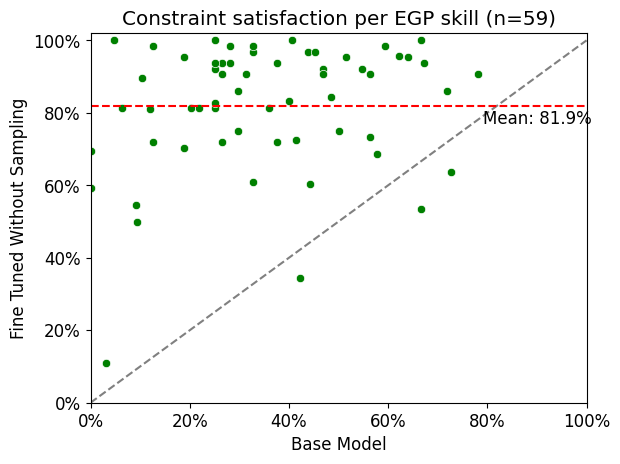

In [13]:
plot_metrics('base_constraint', "Base Model",
             'test_no_sampling_constraint', "Fine Tuned Without Sampling",
             f"Constraint satisfaction per EGP skill (n={len(metrics.keys())})",
            ylim=(0,1.02), xlim=(0,1), diagonal=True, annotate=False, mean='test_no_sampling_constraint',
            y_percent=True, x_percent=True)

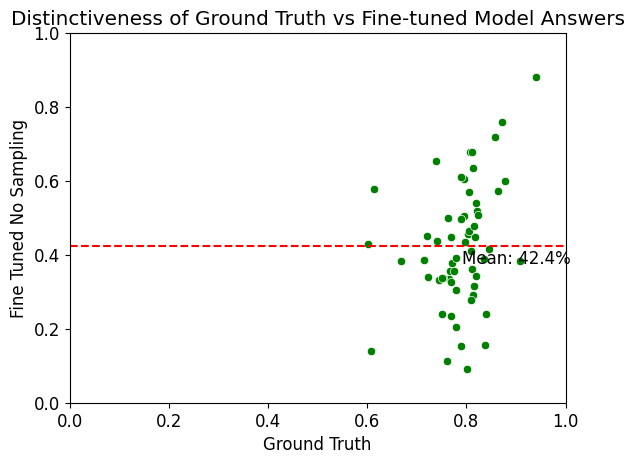

In [20]:
plot_metrics('truth_distinct', "Ground Truth",
             'test_no_sampling_distinct', "Fine Tuned No Sampling",
             "Distinctiveness of Ground Truth vs Fine-tuned Model Answers",
            ylim=(0,1), xlim=(0,1), mean='test_no_sampling_distinct')

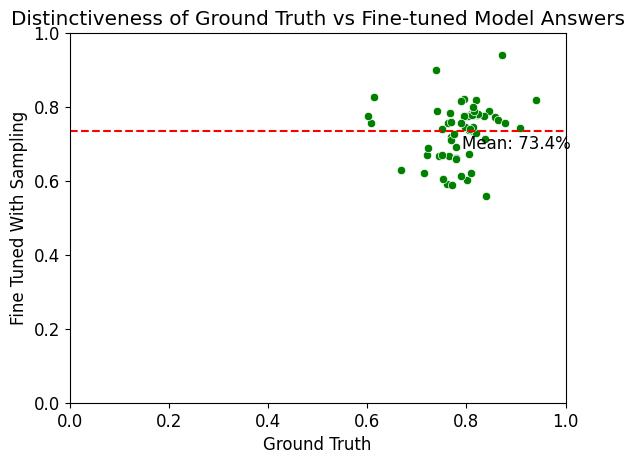

In [21]:
plot_metrics('truth_distinct', "Ground Truth",
             'test_distinct', "Fine Tuned With Sampling",
             "Distinctiveness of Ground Truth vs Fine-tuned Model Answers",
            ylim=(0,1), xlim=(0,1), mean='test_distinct')

/tmp/ipykernel_9502/392149052.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])
/tmp/ipykernel_9502/392149052.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{y:.0%}' for y in plt.gca().get_yticks()])


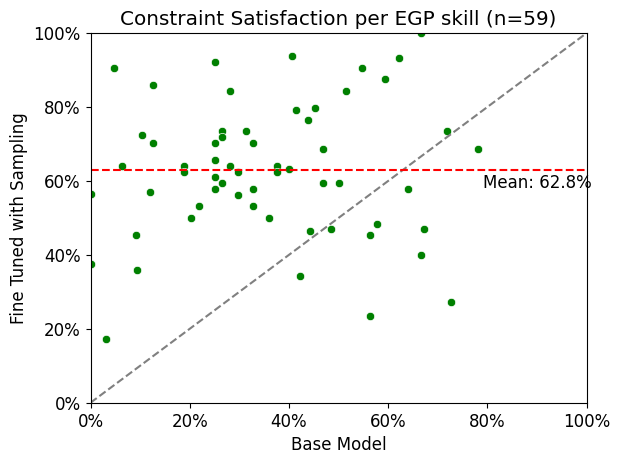

In [14]:
plot_metrics('base_constraint', "Base Model",
             'test_constraint', "Fine Tuned with Sampling",
             "Constraint Satisfaction per EGP skill (n=59)",
            ylim=(0,1), xlim=(0,1), diagonal=True, annotate=False, mean='test_constraint',
            y_percent=True, x_percent=True)

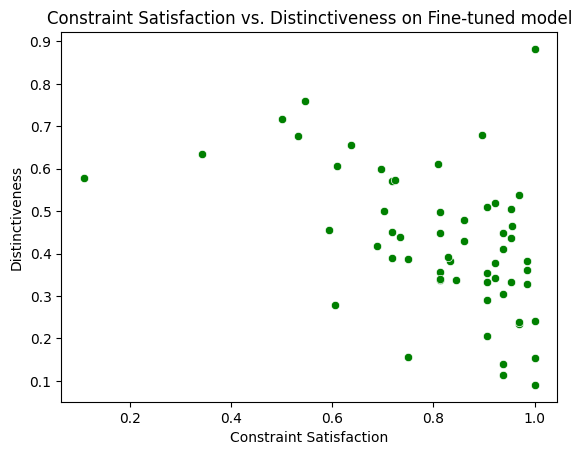

In [22]:
plot_metrics('test_no_sampling_constraint', "Constraint Satisfaction",
             'test_no_sampling_distinct', "Distinctiveness",
             "Constraint Satisfaction vs. Distinctiveness on Fine-tuned model",
             annotate=False)

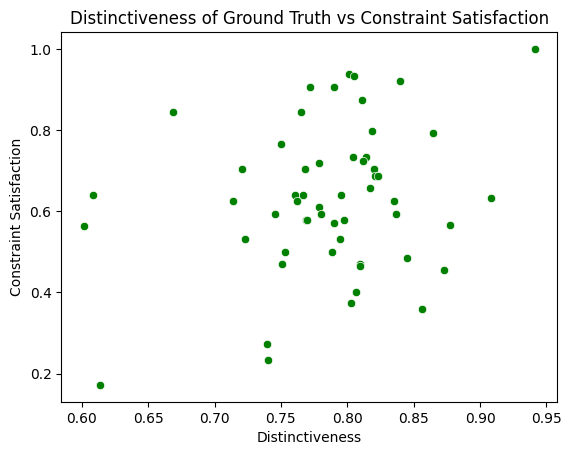

In [12]:
plot_metrics('truth_distinct', "Distinctiveness",
             'test_constraint', "Constraint Satisfaction",
             "Distinctiveness of Ground Truth vs Constraint Satisfaction",
             annotate=False, y_percent=True)

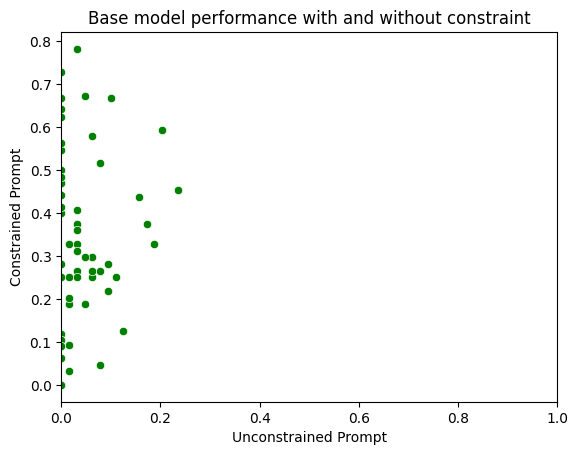

In [13]:
plot_metrics('unconstrained_constraint', "Unconstrained Prompt",
             'base_constraint', "Constrained Prompt",
             "Base model performance with and without constraint",
             annotate=False, xlim=(0,1), y_percent=True)